In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from uteis import plotar_grafico_cotovelo, procurar_num_componentes, obter_distancias_inter, obter_distancias_intra

from numpy.linalg import norm
from PIL import Image

# Importar Dataset

In [ ]:
# Importando o dataset
faces_bunch = fetch_olivetti_faces(shuffle=True)
data = faces_bunch.data
images = faces_bunch.images
targets = faces_bunch.target

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
# Desejo selecionar um número de imagens que não serão aplicadas no
# treino do algoritmo para utilizar de teste posteriormente
def separar_treino_teste(targets):
    indices_teste = []
    ids = np.unique(targets)
    # Para cada pessoa, seleciona aleatoriamente 1 imagem para teste
    for id_pessoa in ids:
        # Encontra os índices de todas as imagens dessa pessoa
        indices = np.where(targets == id_pessoa)[0]
        # Escolhe aleatoriamente 1 índice para teste
        indice_teste = np.random.choice(indices, size=1, replace=False)
        indices_teste.append(indice_teste)

    # Converte para array unidimensional
    indices_teste = np.concatenate(indices_teste)

    # Máscara booleana para separar treino e teste
    mascara_teste = np.zeros(len(targets), dtype=bool)
    mascara_teste[indices_teste] = True  # True = teste, False = treino

    return mascara_teste

mascara_teste = separar_treino_teste(targets)

# Divide-se os dados
data_treino, data_teste = data[~mascara_teste], data[mascara_teste]
targets_treino, targets_teste = targets[~mascara_teste], targets[mascara_teste]

# Obter número de componentes ideal

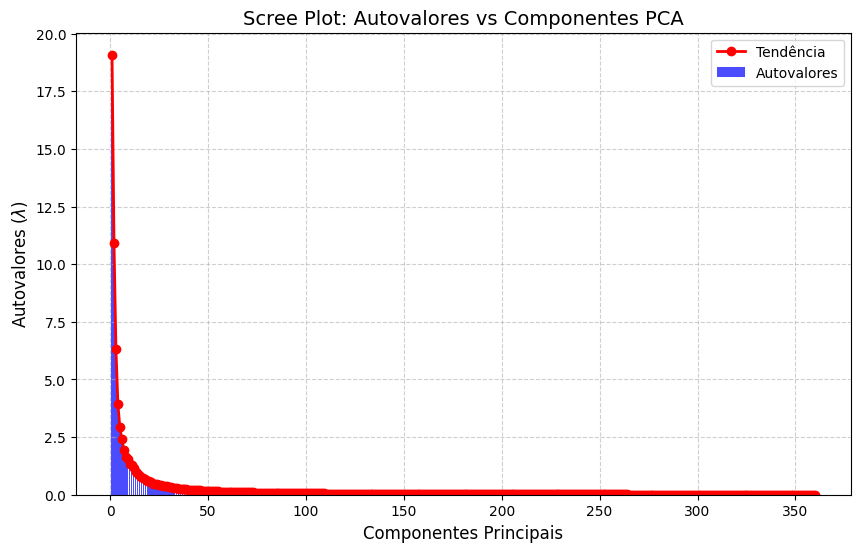

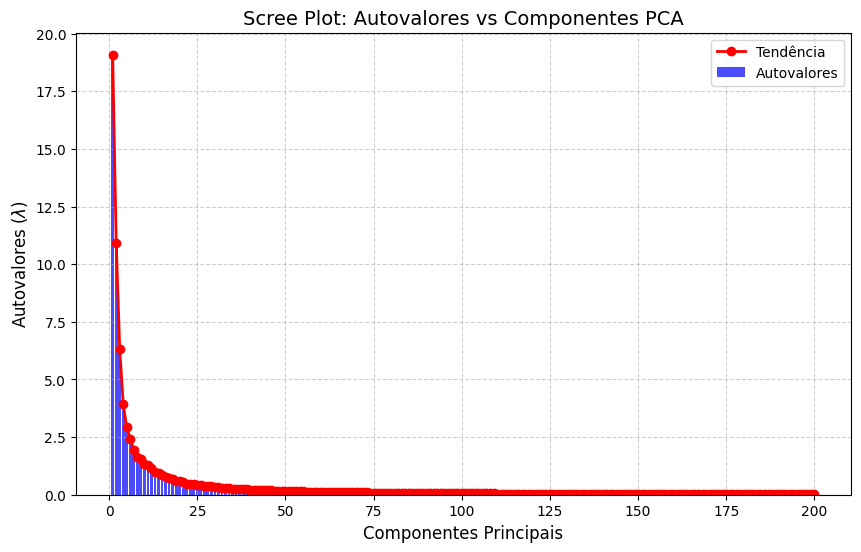

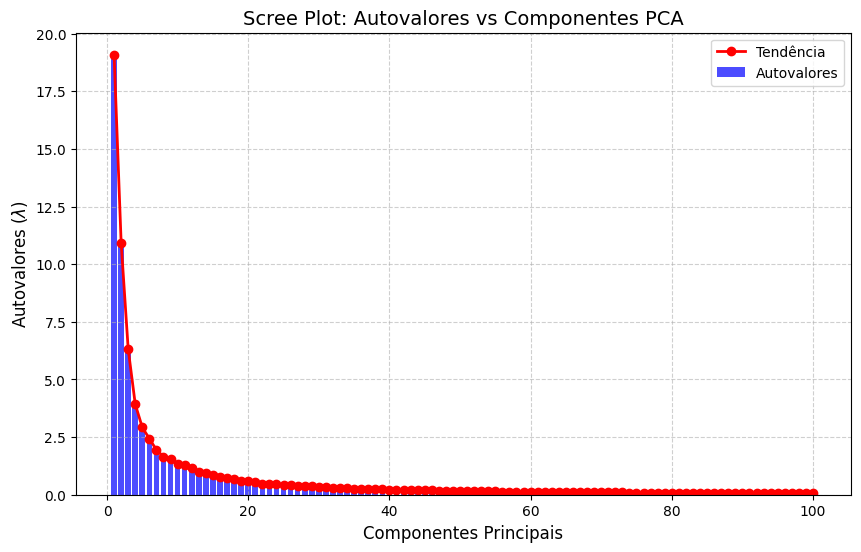

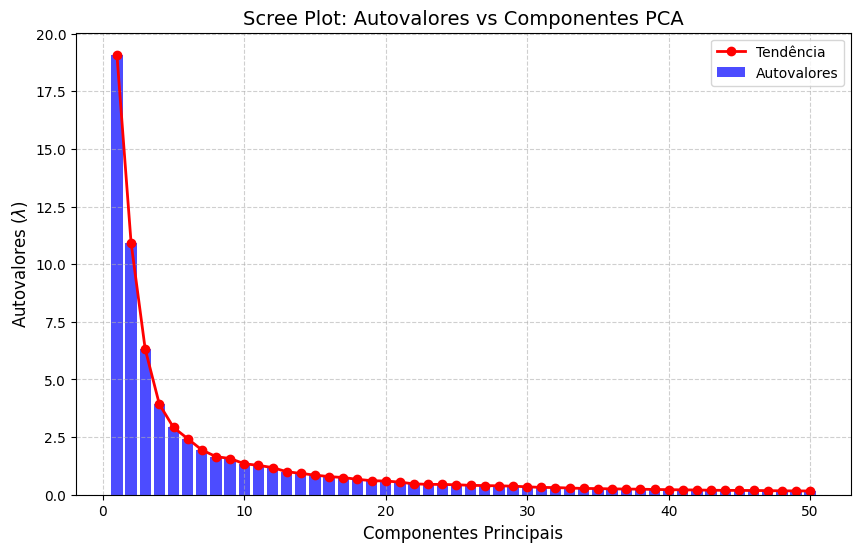

In [9]:
# Esse bloco objetiva a decisão do número de componentes que serão
# escolhidos
pca = PCA(n_components=None)
pca.fit(data_treino)
all_autovalores = pca.explained_variance_
all_autovalores_percentuais = pca.explained_variance_ratio_

# Avalia-se diferentes gráficos cotovelos para obter o número
# de componentes ideal visualmente
plotar_grafico_cotovelo(all_autovalores)
plotar_grafico_cotovelo(all_autovalores[:200])
plotar_grafico_cotovelo(all_autovalores[:100])
plotar_grafico_cotovelo(all_autovalores[:50])

In [11]:
# Matemáticamente agora desejamos obter o número de componentes
# para um determinado percentual de precisão desejado.
percentual_desejado = 0.95
k = procurar_num_componentes(percentual_desejado, all_autovalores_percentuais)
print(f"{k} componentes necessárias para {percentual_desejado * 100} % de precisão")

116 componentes necessárias para 95.0 % de precisão


# Obter as eigenfaces, seus pesos e os autovalores associados

In [12]:
# Aplicação do PCA para o número de componentes obtido no bloco acima
pca = PCA(n_components=k)
pca.fit(data_treino)

eigenfaces = pca.components_    # autovetores da matriz AA^t
eigenfaces_importancia = pca.explained_variance_    # autovalores da matriz AA^t
eigenfaces_importancia_percentual = pca.explained_variance_ratio_   # autovalores percentuais da matriz AA^t
                                                                    # autovalor/sum(autovalores)

projecoes = pca.fit_transform(data_treino) # matriz com os pesos de cada eigenface
                                    # para cada foto do dataset original

data_aprox = pca.inverse_transform(projecoes)  # aproximação da matriz data a partir das projeçoes feitas

# Definindo o limiar de similaridade

In [16]:
# Definindo o limiar de similaridade
ids = np.unique(targets)
distancias_intra = obter_distancias_intra(ids, projecoes, targets_treino)
distancias_inter = obter_distancias_inter(ids, projecoes, targets_treino)

media_intra = np.mean(distancias_intra)
dp_intra = np.std(distancias_intra)

media_inter = np.mean(distancias_inter)
dp_inter = np.std(distancias_inter)

limiar1 = media_intra + 2 * dp_intra    # limiar de similaridade baseado em desvio padrão

In [17]:
def obter_limiar_eer(distancias_intra, distancias_inter):
    # Cria-se vetores de labels (0 = intra-classe, 1 = inter-classe)
    labels = np.concatenate([
        np.zeros(len(distancias_intra)),  # 0 para intra-classe
        np.ones(len(distancias_inter))    # 1 para inter-classe
    ])

    # Concatenar todas as distâncias
    distancias = np.concatenate([distancias_intra, distancias_inter])

    # Calcular FPR e TPR (usando a função ROC do scikit-learn)
    fpr, tpr, limiares = roc_curve(labels, distancias)

    # Encontrar o limiar onde FPR ≈ 1 - TPR (FNR)
    limiar_eer = limiares[np.argmin(np.abs(fpr - (1 - tpr)))]
    
    return limiar_eer

limiar_eer = obter_limiar_eer(distancias_intra, distancias_inter)
print(f"Limiar EER: {limiar_eer}")

Limiar EER: 10.119941711425781


# Utilizando as imagens de teste

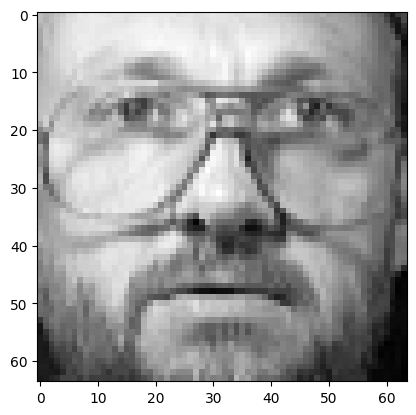

In [32]:
face1 = images[0]
plt.imshow(face1, cmap="gray")
plt.show()

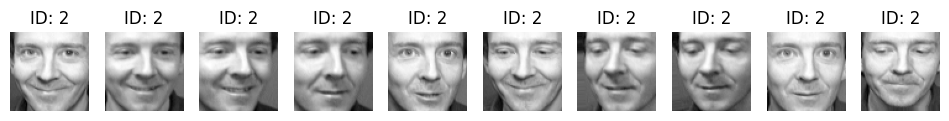

In [116]:
# Filtra apenas imagens da pessoa com ID=7
id_person = 2
person_images = images[targets == id_person]

# Exibe 5 imagens dessa pessoa
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(person_images[i], cmap='gray')
    ax.set_title(f"ID: {id_person}")
    ax.axis('off')

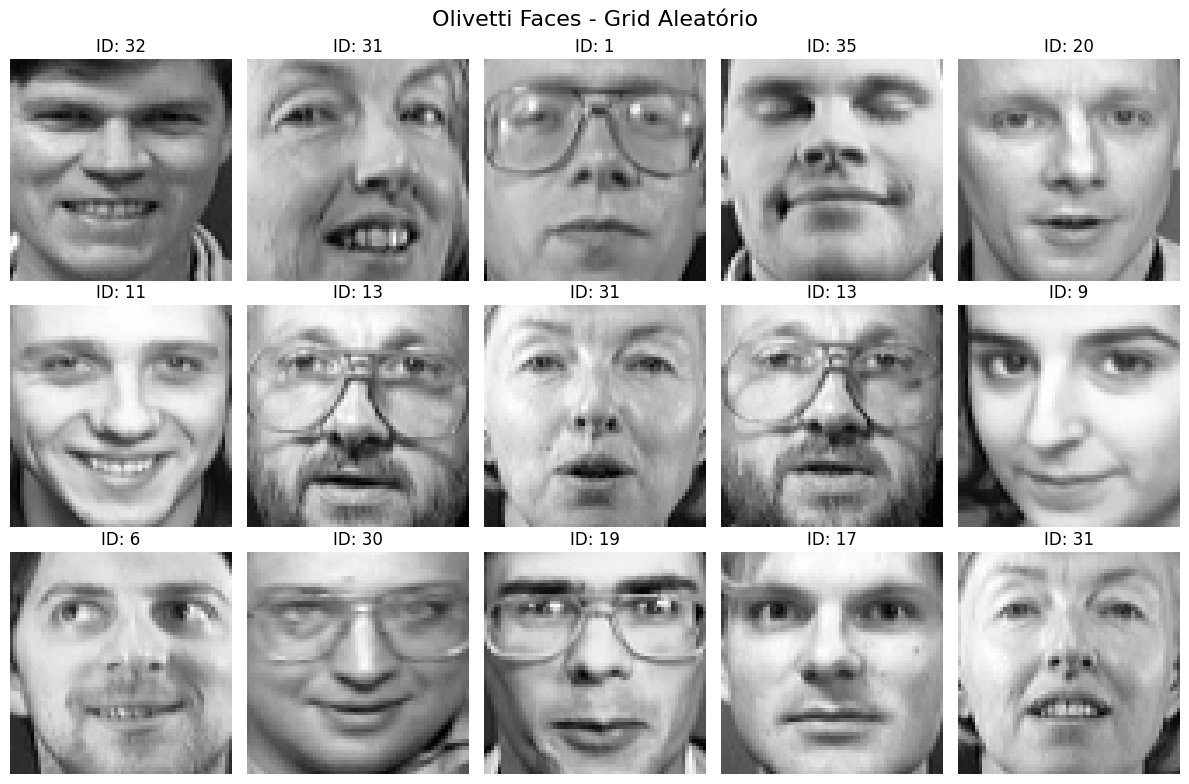

In [11]:
# Configurações do grid
n_rows = 3
n_cols = 5
total_imgs = n_rows * n_cols

# Cria a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
fig.suptitle("Olivetti Faces - Grid Aleatório", fontsize=16)

# Embaralha os índices para pegar imagens aleatórias
random_indices = np.random.choice(len(images), total_imgs, replace=False)

# Preenche o grid
for i, ax in enumerate(axes.flat):
    ax.imshow(images[random_indices[i]], cmap='gray')
    ax.set_title(f"ID: {targets[random_indices[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()